### Imports

In [1]:
import os
import sys

# Configure Google Colab
def set_colab_folder(path='MyDrive/Colab Notebooks/ML4HC/project2'):
  if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/drive/')
    path = os.path.join('/content/drive/', path)
    sys.path.append(path)
    %cd $path

    # upgrade to solve for inconsistencies on Colab
    !pip install scikit-learn==0.22.1
    !pip install -U imbalanced-learn
    !pip install livelossplot
    !pip install glove-python-binary
    
  else:
    print('Not running on CoLab')

Uncomment and run following cell if on Colab

In [ ]:
# set_colab_folder()

In [3]:
# General
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, f1_score, confusion_matrix,
    plot_precision_recall_curve, plot_roc_curve, precision_recall_curve, roc_curve, auc, balanced_accuracy_score)

# Sklearn preprocessing and utility
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Sklearn classifier
from sklearn.ensemble import RandomForestClassifier

# Sampling
from imblearn.under_sampling import EditedNearestNeighbours, NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline as make_pipeline_imbl

# further utility functions
from collections import Counter
from itertools import product 
import warnings
import gc

# Custom helper functions
from cf_matrix import make_confusion_matrix
from utils import *
from data_io import *
from data_representation import *

# Plot settings
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Datasets


In [4]:
# Fix data directory
data_dir = "data"

In [ ]:
# Get dataset shapes
shapes = get_dataset_shapes()
pd.DataFrame(shapes)

,0,1
0,C_elegans_acc_seq.csv,"(2200, 2)"
1,human_dna_test_hidden_split.csv,"(30021, 1)"
2,human_dna_test_split.csv,"(33333, 2)"
3,human_dna_validation_split.csv,"(33333, 2)"
4,human_dna_train_split.csv,"(500000, 2)"
5,C_elegans_validation_split.csv,"(330, 2)"
6,C_elegans_train_split.csv,"(1540, 2)"
7,C_elegans_test_split.csv,"(330, 2)"


# C Elegans
Training and performance report on the C. Elegans dataset

### Read-in datasets

In [5]:
X_train, y_train = get_data(species='worm', mode='train', form='split')
X_val, y_val = get_data(species='worm', mode='val', form='split')
X_test, y_test = get_data(species='worm', mode='test', form='split')

100%|██████████| 330/330 [00:00<00:00, 26828.72it/s]


In [6]:
# Use 0/1 labels instead of -1/1 labels
y_train[y_train < 0] = 0
y_val[y_val < 0] = 0
y_test[y_test < 0] = 0

### Class Distribution

In [7]:
print(f"Training: {Counter(y_train)}")
print(f"Validation: {Counter(y_val)}")
print(f"Test: {Counter(y_test)}")

Training: Counter({0: 1400, 1: 140})
Validation: Counter({0: 300, 1: 30})
Test: Counter({0: 300, 1: 30})


## Data preparation

In [8]:
# One-Hot encode data
X_train = one_hot_encoding(X_train)
X_val = one_hot_encoding(X_val)
X_test = one_hot_encoding(X_test)

In [9]:
# Work with dense data matrices
X_train = np.asarray(X_train.todense())
X_val = np.asarray(X_val.todense())
X_test = np.asarray(X_test.todense())

## Training

### Default setting

In [13]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

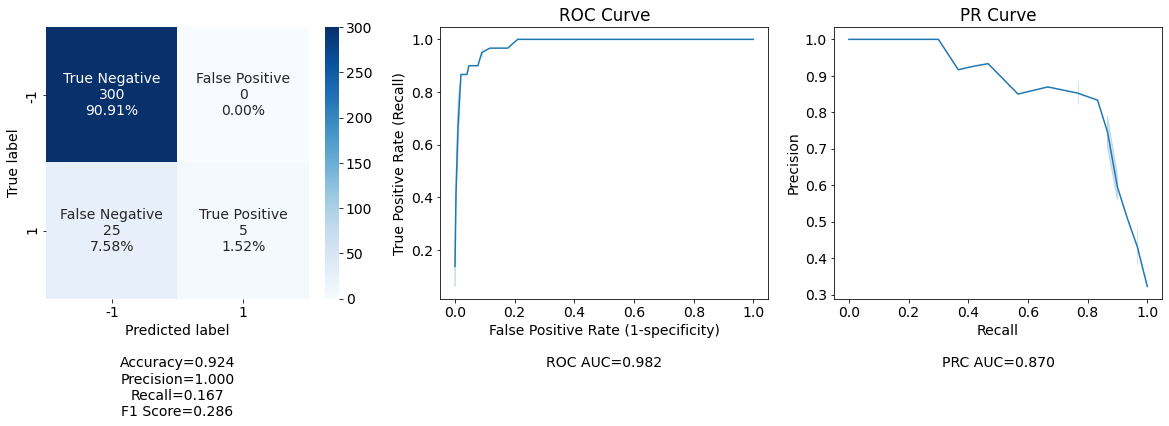

In [14]:
y_proba, y_pred, res = pred_results(clf, X=X_test, y=y_test, model_name = 'default', figsize=(20,5))

### Class weights

In [15]:
cls_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cls_weight_dict = {0: cls_weights[0], 1: cls_weights[1]}

In [16]:
clf_cls = RandomForestClassifier(random_state=42, class_weight=cls_weight_dict)
clf_cls.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.55, 1: 5.5}, random_state=42)

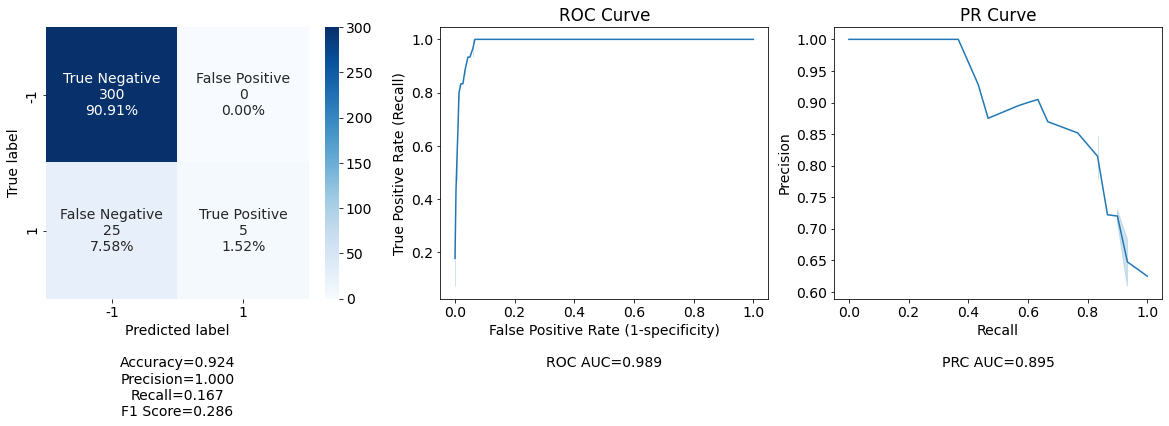

In [17]:
_, _, res_cls = pred_results(clf=clf_cls, X=X_test, y=y_test, model_name="class_weights", figsize=(20,5))

### Hyperparameter search

We tune for multiple parameters of the random forest classifier.

In [ ]:
# Uncomment following line and run to ignore Deprecation Warnings
# warnings.filterwarnings('ignore', category=DeprecationWarning)

In [ ]:
reg_C = np.logspace(-4,0,5)   # default  C=1.0
k_select = range(25,275,25)
scoring_crit = [f_classif, chi2]

n_estimators = [100, 500, 1000]
criterions = ['gini', 'entropy']
max_depths = [3, 5, 10]
max_features = ['sqrt', 'log2']
class_weights = [None, 'balanced', 'balanced_subsample']

hyperparam_rf = pd.DataFrame({'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})

for k, scoring in product(k_select, scoring_crit):

  if k >= X_train.shape[1]:
    k = X_train.shape[1]
    X_k_train = X_train
    X_k_val = X_val
  else:
    selKBest = SelectKBest(score_func=scoring, k=k)
    selKBest.fit(X_train, y_train)
    X_k_train = selKBest.transform(X_train)
    X_k_val = selKBest.transform(X_val)

  for  n, crit, max_depth, max_feats, clw in product( n_estimators, criterions, max_depths, max_features,  class_weights):
  
    model_params = "sel_{}_est_{}_crit_{}_depth_{}_feats_{}_clw_{}".format(k, n, crit, max_depth, max_feats, clw)
    print('Currently at model '+model_params)
    
    clf = RandomForestClassifier(n_estimators=n, 
                                  criterion=crit, 
                                  max_depth=max_depth, 
                                  min_samples_split=5, 
                                  min_samples_leaf=2, 
                                  max_features=max_feats, 
                                  bootstrap=False, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  verbose=0, 
                                  class_weight=clw)
    
    clf.fit(X_k_train, y_train)
    _, _, res_rf= pred_results(clf=clf, X=X_k_val, y=y_val, model_name=model_params, figsize=None)
    hyperparam_rf = pd.concat([hyperparam_rf,res_rf], axis=0).reset_index(drop=True)




We consider the (weighted) average of the four metrics considered (F1-score, balanced accuracy, PRC AUC, ROC AUC).

In [ ]:
hyperparam_rf['avg'] = hyperparam_rf.mean(axis=1)
hyperparam_rf['weighted'] = 0.15*hyperparam_rf['f1-score'] + 0.15*hyperparam_rf['balanced_accuracy'] + 0.35*hyperparam_rf['roc_auc'] + 0.35*hyperparam_rf['prc_auc']

We sort for the parametrizations with highest PRC AUC and afterwards find for each metric the best parametrization.

In [ ]:
hyperparam_rf.sort_values('prc_auc', ascending=False)[:10]

In [ ]:
display(hyperparam_rf.style.highlight_max(color = 'lightgreen', axis = 0))

As the first few models have comparatively similiar performance, we select the least complex one.

**Model with (one of) highest PRC AUC**
*  k_select = 175
*  n_estimators = 100
*  criterions = 'entropy'
*  max_depths =  10
*  max_features = 'log2'
*  class_weights = 'balanced_subsample'

Used for test predicitions below




### Select model for test set predictions

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [120 121 122 123 124 125] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


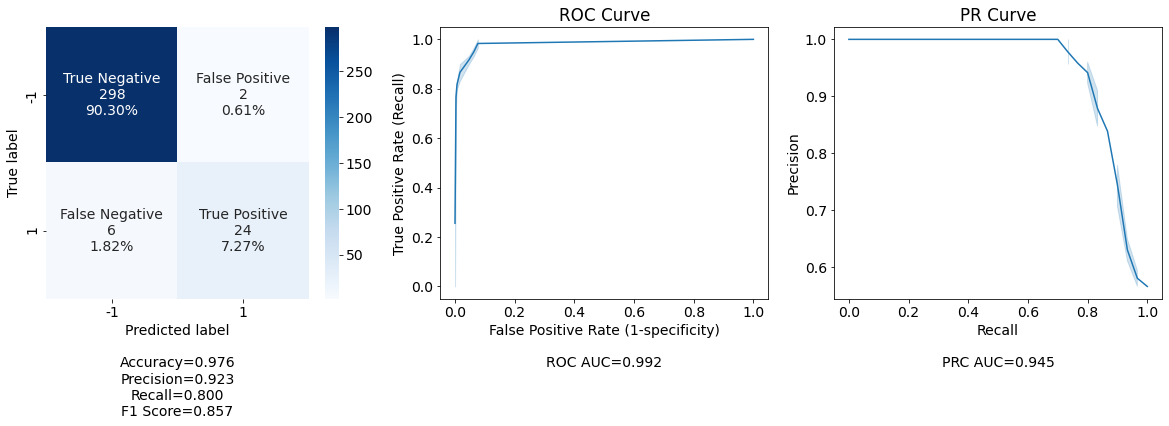

In [18]:
k = 175
n = 100
crit = 'entropy'
max_depth = 10
max_feats = 'log2'
clw = 'balanced_subsample'


model_params = "sel_{}_est_{}_crit_{}_depth_{}_feats_{}_clw_{}".format(k, n, crit, max_depth, max_feats, clw)

selKBest = SelectKBest(score_func=f_classif, k=k)
selKBest.fit(X_train, y_train)

X_k_train = selKBest.transform(X_train)
X_k_test = selKBest.transform(X_test)

clf = RandomForestClassifier(n_estimators=n, 
                              criterion=crit, 
                              max_depth=max_depth, 
                              min_samples_split=5, 
                              min_samples_leaf=2, 
                              max_features=max_feats, 
                              bootstrap=False, 
                              n_jobs=-1, 
                              random_state=42, 
                              verbose=0, 
                              class_weight=clw)

clf.fit(X_k_train, y_train)
y_proba, y_pred, res_tune = pred_results(clf=clf, X=X_k_test, y=y_test, model_name=model_params, figsize=(20,5))

In [19]:
results = pd.concat([res, res_cls, res_tune], axis=0).reset_index(drop=True)

In [20]:
results

,model,f1-score,balanced_accuracy,roc_auc,prc_auc
0,default,0.924242,0.583333,0.981500,0.870137
1,class_weights,0.924242,0.583333,0.988833,0.895474
2,sel_175_est_100_crit_entropy_depth_10_feats_lo...,0.975758,0.896667,0.992222,0.944759


Uncomment and run following cell to output test predictions

In [21]:
# # replace label 0 by -1 again
# y_pred[y_pred < 0.5]=-1

# pd.DataFrame(y_pred).to_csv("./predictions/worm_test_rf_est100_dep10_select175.csv")
# pd.DataFrame(y_proba).to_csv("./predictions/proba_worm_test_rf_est100_dep10_select175.csv")

### Analysis with k-mers

We use one-hot encoding of k-mers for k=1,...,5 and tune for optimal k-select.

In [ ]:
warnings.filterwarnings('ignore') 

representation = '1-hot'
form = 'split'
species = 'worm'

k_mers = [1,2,3,4,5]
k_selects = range(25,1000,25)

scoring = f_classif
n = 100
crit = 'gini'
max_depth = 10
max_feats = 'log2'
clw = 'balanced_subsample'


kmer_best_res = pd.DataFrame({'k_mer':[], 'k_select':[], 'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})


for k in [1,2,3,4,5]:

  X_train, y_train = get_data(species, form=form, mode='train', k=k) 
  X_val, y_val = get_data(species, form=form, mode='val', k=k) 
  # X_test, y_test = get_data(species, form=form, mode='test', k=k) 

  y_train[y_train < 0] = 0
  y_val[y_val < 0] = 0
  # y_test[y_test < 0] = 0

  X_train = one_hot_encoding(X_train, form='1d', k=k)
  X_val = one_hot_encoding(X_val, form='1d', k=k)
  # X_test = one_hot_encoding(X_test, form='1d', k=k)

  X_train = np.asarray(X_train.todense())
  X_val = np.asarray(X_val.todense())
  # X_test = np.asarray(X_test.todense())

  for k_sel in k_selects:

    if k_sel > X_train.shape[1]: continue

    selKBest = SelectKBest(score_func=f_classif, k=k_sel)
    selKBest.fit(X_train, y_train)

    X_k_train = selKBest.transform(X_train)
    X_k_val = selKBest.transform(X_val)

    clf_k = RandomForestClassifier(n_estimators=n, 
                              criterion=crit, 
                              max_depth=max_depth, 
                              min_samples_split=5, 
                              min_samples_leaf=2, 
                              max_features=max_feats, 
                              bootstrap=False, 
                              n_jobs=-1, 
                              random_state=42, 
                              verbose=0, 
                              class_weight=clw)


    clf_k.fit(X_k_train, y_train)
    y_proba, y_pred, res_kmer = pred_results(clf=clf_k, X=X_k_val, y=y_val, model_name="{}-mer_sel_{}_est_{}_crit_{}_depth_{}_feats_{}_clw_{}".format(k,k_sel, n, crit, max_depth, max_feats, clw), figsize=None)

    kmer_best_res = pd.concat([kmer_best_res, pd.concat([pd.DataFrame([[k,k_sel]],columns=['k_mer','k_select']),res_kmer], axis=1) ], axis=0).reset_index(drop=True)

In [ ]:
kmer_best_res['avg'] = kmer_best_res.iloc[:,3:].mean(axis=1)
kmer_best_res['weighted'] = 0.15*kmer_best_res['f1-score'] + 0.15*kmer_best_res['balanced_accuracy'] + 0.35*kmer_best_res['roc_auc'] + 0.35*kmer_best_res['prc_auc'] 

In [ ]:
kmer_best_res.sort_values('prc_auc', ascending=False).iloc[:10,:]

In [ ]:
display(kmer_best_res.style.highlight_max(color = 'lightgreen', axis = 0))

Based on the highest PRC AUC, we select the following model and apply it on the test set.

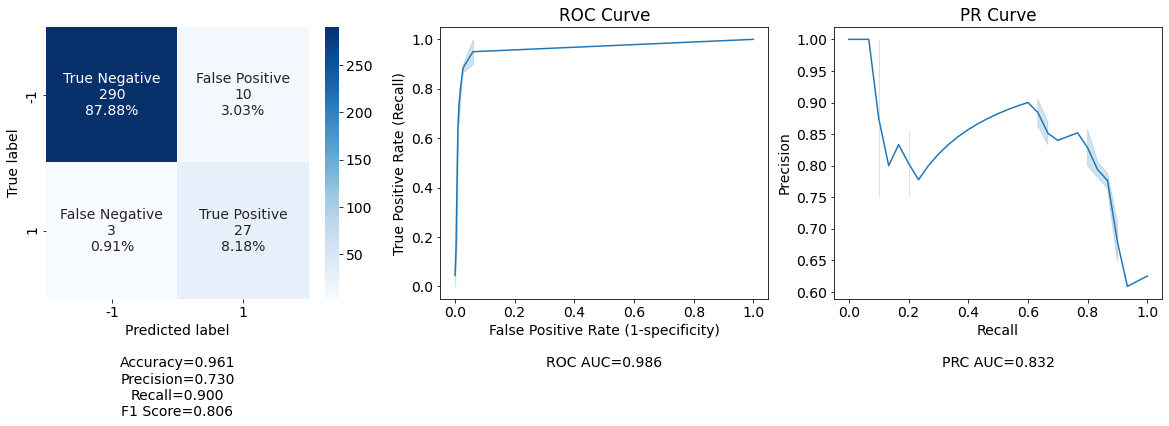

In [ ]:
k_mer = 2
k_sel = 900
n = 100
crit = 'gini'
max_depth = 10
max_feats = 'log2'
class_weights = 'balanced_subsample'

model_params = "{}-mer_sel_{}_est_{}_crit_{}_depth_{}_feats_{}_clw_{}".format(k_mer, k_sel, n, crit, max_depth, max_feats, clw)

X_train, y_train = get_data(species, form=form, mode='train', k=k_mer) 
X_test, y_test = get_data(species, form=form, mode='test', k=k_mer) 

y_train[y_train < 0] = 0
y_test[y_test < 0] = 0

X_train = one_hot_encoding(X_train, form='1d', k=k_mer)
X_test = one_hot_encoding(X_test, form='1d', k=k_mer)

X_train = np.asarray(X_train.todense())
X_test = np.asarray(X_test.todense())


selKBest = SelectKBest(score_func=f_classif, k=k_sel)
selKBest.fit(X_train, y_train)

X_k_train = selKBest.transform(X_train)
X_k_test = selKBest.transform(X_test)

clf = RandomForestClassifier(n_estimators=n, 
                              criterion=crit, 
                              max_depth=max_depth, 
                              min_samples_split=5, 
                              min_samples_leaf=2, 
                              max_features=max_feats, 
                              bootstrap=False, 
                              n_jobs=-1, 
                              random_state=42, 
                              verbose=0, 
                              class_weight=clw)

clf.fit(X_k_train, y_train)
y_proba, y_pred, res_tune = pred_results(clf=clf, X=X_k_test, y=y_test, model_name=model_params, figsize=(20,5))

In [ ]:
res_tune

,model,f1-score,balanced_accuracy,roc_auc,prc_auc
0,2-mer_sel_900_est_100_crit_gini_depth_10_feats...,0.960606,0.933333,0.986333,0.831615


In comparison to the previously best model, the PRC AUC on the test set is worse. We now combine the one-hot encodings of k-mers for k=1,2 and 3. We again tune k-select and select the parametrization with the highest validation PRC AUC. We then apply this model on the test dataset.

In [ ]:
representation = '1-hot'
form = 'split'
species = 'worm'
k_max = 3

X_train, y_train = get_data(species, form=form, mode='train', k=1) 
X_val, y_val = get_data(species, form=form, mode='val', k=1) 
X_test, y_test = get_data(species, form=form, mode='test', k=1) 

X_train = one_hot_encoding(X_train, form='1d', k=1)
X_val = one_hot_encoding(X_val, form='1d', k=1)
X_test = one_hot_encoding(X_test, form='1d', k=1)

X_train = np.asarray(X_train.todense())
X_val = np.asarray(X_val.todense())
X_test = np.asarray(X_test.todense())

y_train[y_train < 0] = 0
y_val[y_val < 0] = 0
y_test[y_test < 0] = 0


for k in range(2,k_max + 1):
  X_train_temp, _ = get_data(species, form=form, mode='train', k=k) 
  X_val_temp, _ = get_data(species, form=form, mode='val', k=k) 
  X_test_temp, _ = get_data(species, form=form, mode='test', k=k) 

  X_train_temp = one_hot_encoding(X_train_temp, form='1d', k=k)
  X_val_temp = one_hot_encoding(X_val_temp, form='1d', k=k)
  X_test_temp = one_hot_encoding(X_test_temp, form='1d', k=k)

  X_train_temp = np.asarray(X_train_temp.todense())
  X_val_temp = np.asarray(X_val_temp.todense())
  X_test_temp = np.asarray(X_test_temp.todense())

  X_train = np.concatenate([X_train, X_train_temp ], axis=1)
  X_val = np.concatenate([X_val, X_val_temp ], axis=1)
  X_test = np.concatenate([X_test, X_test_temp ], axis=1)

In [ ]:
cum_kmer_best_res = pd.DataFrame({'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})

k_selects = range(100,3100,50)
scoring = f_classif
n = 100
crit = 'gini'
max_depth = 10
max_feats = 'log2'
clw = 'balanced_subsample'

for k_sel in k_selects:

    if k_sel > X_train.shape[1]: continue

    selKBest = SelectKBest(score_func=f_classif, k=k_sel)
    selKBest.fit(X_train, y_train)

    X_k_train = selKBest.transform(X_train)
    X_k_val = selKBest.transform(X_val)

    clf_k = RandomForestClassifier(n_estimators=n, 
                              criterion=crit, 
                              max_depth=max_depth, 
                              min_samples_split=5, 
                              min_samples_leaf=2, 
                              max_features=max_feats, 
                              bootstrap=False, 
                              n_jobs=-1, 
                              random_state=42, 
                              verbose=0, 
                              class_weight=clw)    
    
    clf_k.fit(X_k_train, y_train)
    y_proba, y_pred, res_cum_kmer = pred_results(clf=clf_k, X=X_k_val, y=y_val, model_name="cum_mer_sel_{}_est_{}_crit_{}_depth_{}_feats_{}_clw_{}".format(k_sel, n, crit, max_depth, max_feats, clw), figsize=None)

    cum_kmer_best_res = pd.concat([cum_kmer_best_res, res_cum_kmer], axis=0).reset_index(drop=True)

In [ ]:
cum_kmer_best_res['avg'] = cum_kmer_best_res.mean(axis=1)
cum_kmer_best_res['weighted'] = 0.15*cum_kmer_best_res['f1-score'] + 0.15*cum_kmer_best_res['balanced_accuracy'] + 0.35*cum_kmer_best_res['roc_auc'] + 0.35*cum_kmer_best_res['prc_auc'] 

In [ ]:
cum_kmer_best_res.sort_values('prc_auc', ascending=False)[:10]

In [ ]:
k_sel = 2650
n = 100
crit = 'gini'
max_depth = 10
max_feats = 'log2'
class_weights = 'balanced_subsample'

model_params = "cum_mer_sel_{}_est_{}_crit_{}_depth_{}_feats_{}_clw_{}".format( k_sel, n, crit, max_depth, max_feats, clw)

selKBest = SelectKBest(score_func=f_classif, k=k_sel)
selKBest.fit(X_train, y_train)

X_k_train = selKBest.transform(X_train)
X_k_test = selKBest.transform(X_test)

clf = RandomForestClassifier(n_estimators=n, 
                              criterion=crit, 
                              max_depth=max_depth, 
                              min_samples_split=5, 
                              min_samples_leaf=2, 
                              max_features=max_feats, 
                              bootstrap=False, 
                              n_jobs=-1, 
                              random_state=42, 
                              verbose=0, 
                              class_weight=clw)

clf.fit(X_k_train, y_train)
y_proba, y_pred, res_cum_mer = pred_results(clf=clf, X=X_k_test, y=y_test, model_name=model_params, figsize=None)

In [ ]:
res_cum_mer

,model,f1-score,balanced_accuracy,roc_auc,prc_auc
0,cum_mer_sel_2650_est_100_crit_gini_depth_10_fe...,0.969697,0.968333,0.991556,0.910634


We slightly improved the PRC_AUC from 0.895 to 0.910 by using a much larger one-hot encoded dataset. It is debatable whether this improvement is significant enough for better a generalization capability to justify the increase in complexity.

# Human DNA

### Read-in Datasets

In [ ]:
X_train, y_train = get_data(species='human', mode='train', form='split')
X_val, y_val = get_data(species='human', mode='val', form='split')
X_test, y_test = get_data(species='human', mode='test', form='split')
X_hidden, _   = get_data(species='human', mode='hidden', form='split')

100%|██████████| 30021/30021 [00:01<00:00, 18960.34it/s]


In [ ]:
# Use 0/1 labels
y_train[y_train < 0] = 0
y_val[y_val < 0] = 0
y_test[y_test < 0] = 0

### Class Distribution

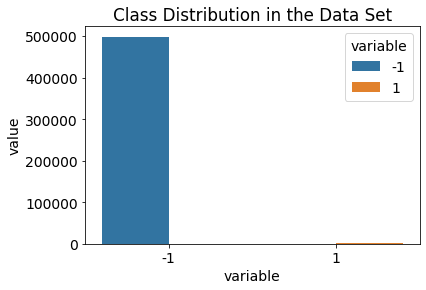

In [ ]:
plot_class_distribution(y_train)

In [ ]:
print(f"Training: {Counter(y_train)}")
print(f"Validation: {Counter(y_val)}")
print(f"Test: {Counter(y_test)}")

Counter({0: 498529, 1: 1471})

## Data preparation

In [ ]:
print("Convert training sets")
X_tot = np.vstack([X_train, X_val, X_test])
X_tot = one_hot_encoding(X_tot)
l_train, l_val, l_test = len(X_train), len(X_val), len(X_test)
X_train, X_val, X_test = X_tot[:l_train], X_tot[l_train:l_train+l_val], X_tot[-l_test:]

print("Convert test set")
X_hidden = one_hot_encoding(X_hidden)

Convert training sets
Convert test set


**Report imbalance on the different splits.**

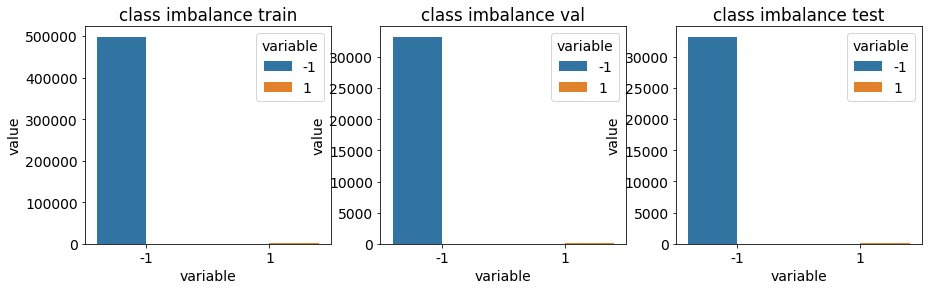

In [ ]:
fig = plt.figure(figsize=(15,4))
gs = fig.add_gridspec(1, 3)

for i, y_ in enumerate([y_train, y_val, y_test]):
  ax = fig.add_subplot(gs[i])
  plot_class_distribution(y_)
  ax.set_title("class imbalance " + ['train','val', 'test'][i])

In [ ]:
# Work with dense datasets
# X_train = np.asarray(X_train.todense())
# X_val = np.asarray(X_val.todense())
# X_test = np.asarray(X_test.todense())
# X_hidden = np.asarray(X_hidden.todense())

## Training

### Default setting

In [ ]:
%%time
clf = RandomForestClassifier(random_state=42) # 33 min
clf.fit(X_train, y_train)

CPU times: user 22min 35s, sys: 963 ms, total: 22min 36s
Wall time: 22min 31s


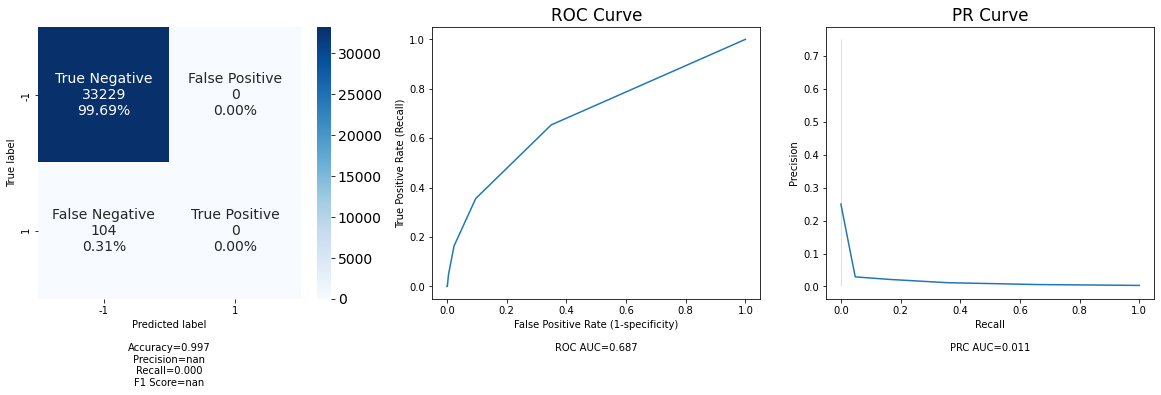

In [ ]:
_, _, res_rf = pred_results(clf, X=X_test, y=y_test, model_name = 'default', figsize=(20,5))

### Class weights

In [ ]:
cls_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cls_weight_dict = {0: cls_weights[0], 1: cls_weights[1]}

In [ ]:
clf_cls = RandomForestClassifier(random_state=42, class_weight=cls_weight_dict)
clf_cls.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.5014753404516087,
                                     1: 169.9524133242692},
                       random_state=42)

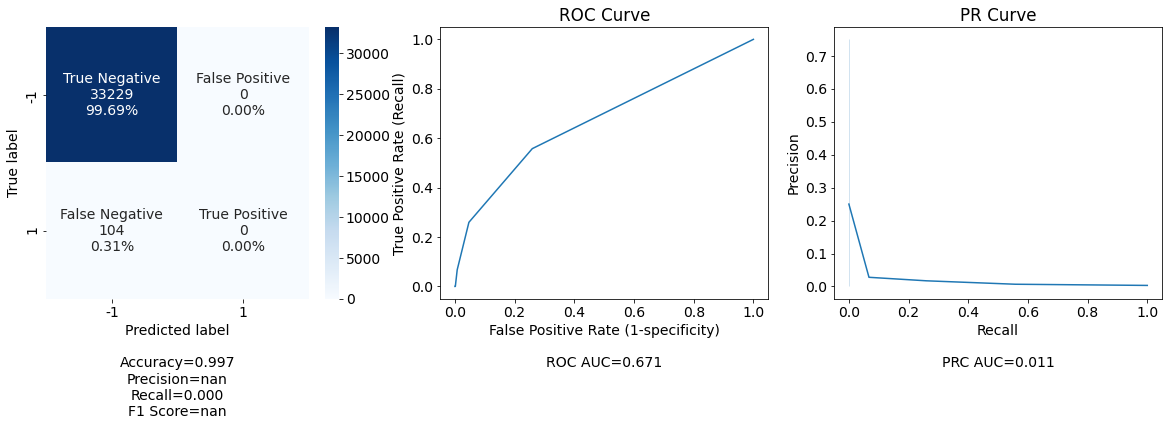

In [ ]:
_, _, res_cls = pred_results(clf=clf_cls, X=X_test, y=y_test, model_name="class_weights", figsize=(20,5))

### Hyperparameter search

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
n_estimators = [100, 500, 1000]
criterions = ['entropy']
max_depths = [5, 10]
max_features = ['log2']
class_weights = ['balanced_subsample']
k_select = list(range(50,275,50)) + [99999] # 99999 will pick full dataset

hyperparam_human_rf = pd.DataFrame({'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})

for k in k_select:

  if k >= X_train.shape[1]:
    k = X_train.shape[1]
    X_k_train = X_train
    X_k_val = X_val
  else:
    selKBest = SelectKBest(score_func=f_classif, k=k)
    selKBest.fit(X_train, y_train)
    X_k_train = selKBest.transform(X_train)
    X_k_val = selKBest.transform(X_val)

  for  n, crit, max_depth, max_feats, clw in product(n_estimators, criterions, max_depths, max_features,  class_weights):
    model_params = "sel_{}_est_{}_crit_{}_depth_{}_feats_{}_clw_{}".format(k, n, crit, max_depth, max_feats, clw)
    print(model_params)
    
    clf = RandomForestClassifier(n_estimators=n, 
                                  criterion=crit, 
                                  max_depth=max_depth, 
                                  min_samples_split=5, 
                                  min_samples_leaf=2, 
                                  max_features=max_feats, 
                                  bootstrap=False, 
                                  # n_jobs=-1, 
                                  random_state=42, 
                                  verbose=0, 
                                  class_weight=clw)
    
    clf.fit(X_k_train, y_train)
    _, _, res_rf = pred_results(clf=clf, X=X_k_val, y=y_val, model_name=model_params, figsize=None)
    hyperparam_human_rf = pd.concat([hyperparam_human_rf, res_rf], axis=0).reset_index(drop=True)

    gc.collect()

In [ ]:
hyperparam_human_rf['avg'] = hyperparam_human_rf.mean(axis=1)
hyperparam_human_rf['weighted'] = 0.15*hyperparam_human_rf['f1-score'] + 0.15*hyperparam_human_rf['balanced_accuracy'] + 0.35*hyperparam_human_rf['roc_auc'] + 0.35*hyperparam_human_rf['prc_auc'] 

In [ ]:
hyperparam_human_rf.sort_values('prc_auc', ascending=False)[:10]

In [ ]:
display(hyperparam_human_rf.style.highlight_max(color = 'lightgreen', axis = 0))

### Select model for test set predictions

Based on best result wrt PRC AUC, we use the following parametrization for the predicition on the test set:

*   Criterion: entropy
*   number estimators: 1000
* depth: 10
* max features: log2
* class weights: 'balanced_subsample'
*   150 k-best features according to f_classif score


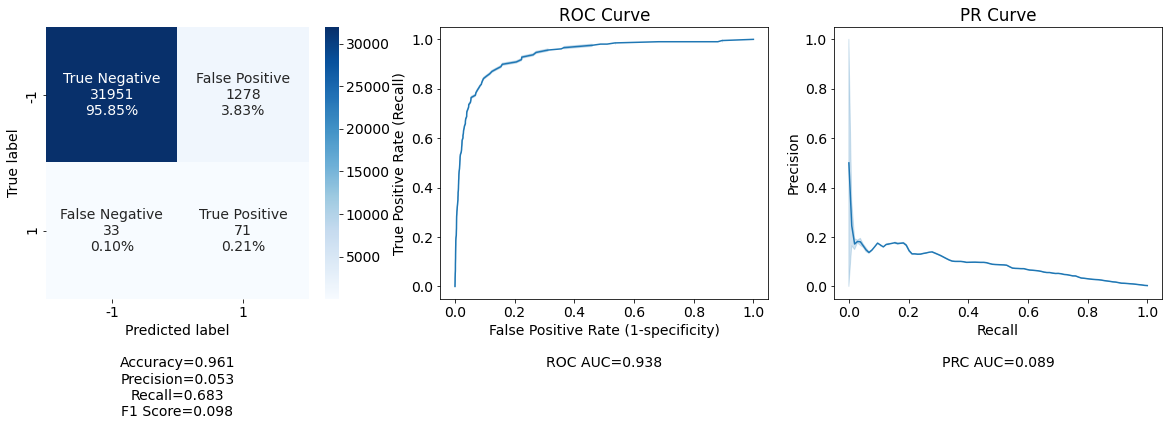

In [ ]:
k = 150
n = 1000
crit = 'entropy'
max_depth = 10
max_feats = 'log2'
clw = 'balanced_subsample'
	
model_params = "sel_{}_est_{}_crit_{}_depth_{}_feats_{}_clw_{}".format(k, n, crit, max_depth, max_feats, clw)

selKBest = SelectKBest(score_func=f_classif, k=k)
selKBest.fit(X_train, y_train)

X_k_train = selKBest.transform(X_train)
X_k_test = selKBest.transform(X_test)
X_k_hidden = selKBest.transform(X_hidden)

clf_k = RandomForestClassifier(n_estimators=n, 
                              criterion=crit, 
                              max_depth=max_depth, 
                              min_samples_split=5, 
                              min_samples_leaf=2, 
                              max_features=max_feats, 
                              bootstrap=False, 
                              n_jobs=-1, 
                              random_state=42, 
                              verbose=0, 
                              class_weight=clw)

clf_k.fit(X_k_train, y_train)
proba_test, pred_test, res_test  = pred_results(clf=clf_k, X=X_k_test, y=y_test, model_name=model_params, figsize=(20,5))

# replace label 0 by -1 again
pred_test[pred_test < 0.5]=-1

In [ ]:
pred_hidden = clf_k.predict(X_k_hidden)
# replace label 0 by -1 again
pred_hidden[pred_hidden<0.5]=-1

proba_hidden = clf_k.predict_proba(X_k_hidden)

In [ ]:
results = pd.concat([res_rf, res_cls, res_test], axis=0).reset_index(drop=True)

In [ ]:
results

,model,f1-score,balanced_accuracy,roc_auc,prc_auc
0,default,0.99688,0.500000,0.686755,0.010875
1,class_weights,0.99688,0.500000,0.670546,0.010975
2,sel_150_est_1000_crit_entropy_depth_10_feats_l...,0.96067,0.822116,0.938313,0.089300


The tuned model has indeed the best PRC AUC, albeit quite low.


#### Create test predicition output for public and hidden dataset

In [ ]:
pd.DataFrame(pred_test).to_csv("./predictions/human_test_rf_est{}_sel{}.csv".format(n,k))
pd.DataFrame(proba_test).to_csv("./predictions/proba_human_test_rf_est{}_sel{}.csv".format(n,k))

pd.DataFrame(pred_hidden).to_csv("./predictions/human_test_hidden_rf_est{}_sel{}.csv".format(n,k))
pd.DataFrame(proba_hidden).to_csv("./predictions/proba_human_test_hidden_rf_est{}_sel{}.csv".format(n,k))

### k-mer analysis

Adding k-mers slightly improved the PRC AUC; similar to the C. elegans dataset. But in comparison to other model classes, it was still not competitve. Thus, the analysis is not presented here. 